In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = "0"
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
from tqdm.auto import tqdm
import torch
from torch import nn
import gin
import ray
import pickle
import io
gin.enter_interactive_mode()
from causal_util import load_env
from causal_util.helpers import lstdct2dctlst
from sparse_causal_model_learner_rl.loss.losses import fit_loss
from sparse_causal_model_learner_rl.loss.causal_discriminator import siamese_feature_discriminator_l2

from sparse_causal_model_learner_rl.metrics.context_rewrite import context_rewriter
from sparse_causal_model_learner_rl.visual.learner_visual import graph_for_matrices
from sparse_causal_model_learner_rl.config import Config
from sparse_causal_model_learner_rl.sacred_gin_tune.sacred_wrapper import load_config_files
from sparse_causal_model_learner_rl.learners.rl_learner import CausalModelLearnerRL

In [2]:
load_config_files(['../sparse_causal_model_learner_rl/configs/kc_rec_nonlin_gnn_gumbel_siamese_l2-Copy1.gin',
                   '../sparse_causal_model_learner_rl/configs/kc_dec.gin',
                   '../keychest/config/5x5_1f1c1k_obs.gin'])

['kc_rec_nonlin_gnn_gumbel_siamese_l2-Copy1', 'kc_dec', '5x5_1f1c1k_obs']

In [6]:
gin.bind_parameter('Config.collect_remotely', True)
gin.bind_parameter('Config.n_collectors', 9)
gin.bind_parameter('Config.env_steps', 5000)
gin.bind_parameter('Config.future_buffer_size', 30)
gin.bind_parameter('Normalizer.type_', 'meanstd')
gin.bind_parameter('ManyNetworkCombinedModel.input_batchnorm', True)

In [7]:
ray.init(ignore_reinit_error=True)

2021-02-05 16:25:02,884	ERROR worker.py:660 -- Calling ray.init() again after it has already been called.


In [8]:
gin.bind_parameter('decoder/FCNet.hidden_sizes', [512])
gin.bind_parameter('decoder/FCNet.activation_cls', torch.nn.LeakyReLU)

In [9]:
learner = CausalModelLearnerRL(Config(ray_kwargs={'address': '127.0.0.1:6379'}))

2021-02-05 16:25:04,328	WARNING session.py:20 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Selecting name 521e86d4-67c6-11eb-8cea-27b3d2a97921
Make environment KeyChest-v0 None {}


In [10]:
learner.create_trainables()

(pid=27940) Make environment KeyChest-v0 None {}
(pid=27933) Make environment KeyChest-v0 None {}
(pid=27932) Make environment KeyChest-v0 None {}
(pid=27935) Make environment KeyChest-v0 None {}
(pid=27931) Make environment KeyChest-v0 None {}
(pid=27938) Make environment KeyChest-v0 None {}
(pid=27939) Make environment KeyChest-v0 None {}
(pid=27936) Make environment KeyChest-v0 None {}
(pid=27934) Make environment KeyChest-v0 None {}


In [11]:
env = learner.env

In [12]:
losses = []
dplus = []

In [13]:
opt = torch.optim.Adam(lr=1e-3, params=learner.decoder.parameters())

In [16]:
for i in tqdm(range(1000)):
    if i % 1 == 0:
        ctx = learner.collect_and_get_context()
    
    opt.zero_grad()
    l_obj = siamese_feature_discriminator_l2(**ctx)
    loss = l_obj['loss']
    loss.backward()
    opt.step()
    losses.append(loss.item())
    dplus.append(l_obj['metrics']['distance_plus'])

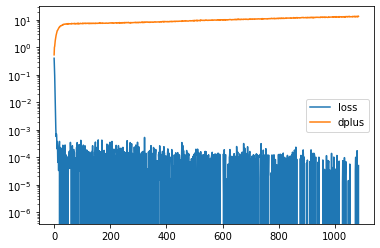

In [17]:
plt.plot(losses, label='loss')
plt.plot(dplus, label='dplus')
plt.yscale('log')
plt.legend()

In [18]:
np.mean(losses[-50:]), np.median(losses[-50:])

(1.3289857106428826e-05, 0.0)

In [19]:
features = learner.decoder(ctx['obs'])

(pid=27932) E0205 16:34:06.201529 27932 27932 plasma_store_provider.cc:113] Failed to put object 43b4f69ac624688f62223d850100000001000000 in object store because it is full. Object size is 47770427 bytes.
(pid=27932) Waiting 1000ms for space to free up...
(pid=raylet) E0205 16:34:06.201200 27885 27900 store.cc:256] Not enough memory to create the object 43b4f69ac624688f62223d850100000001000000, data_size=47770427, metadata_size=6, will send a reply of PlasmaError::OutOfMemory


In [20]:
f = features.detach().cpu().numpy()

In [21]:
f.shape

(5003, 30)

(pid=27932) E0205 16:34:07.203457 27932 27932 plasma_store_provider.cc:113] Failed to put object 43b4f69ac624688f62223d850100000001000000 in object store because it is full. Object size is 47770427 bytes.
(pid=27932) Waiting 2000ms for space to free up...
(pid=raylet) E0205 16:34:07.203158 27885 27900 store.cc:256] Not enough memory to create the object 43b4f69ac624688f62223d850100000001000000, data_size=47770427, metadata_size=6, will send a reply of PlasmaError::OutOfMemory


(pid=27932) E0205 16:34:09.204057 27932 27932 plasma_store_provider.cc:113] Failed to put object 43b4f69ac624688f62223d850100000001000000 in object store because it is full. Object size is 47770427 bytes.
(pid=27932) Waiting 4000ms for space to free up...
(pid=raylet) E0205 16:34:09.203913 27885 27900 store.cc:256] Not enough memory to create the object 43b4f69ac624688f62223d850100000001000000, data_size=47770427, metadata_size=6, will send a reply of PlasmaError::OutOfMemory


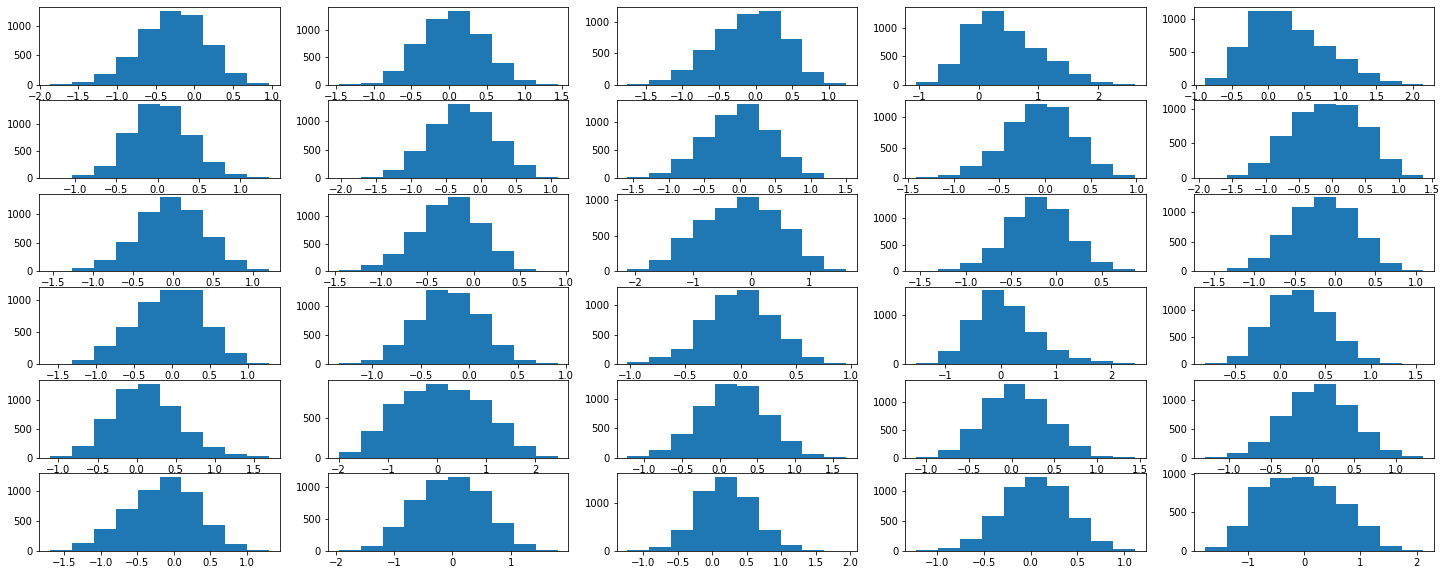

In [22]:
plt.figure(figsize=(25, 10))
for i_f in range(f.shape[1]):
    plt.subplot(6, 5, i_f + 1)
    plt.hist(f[:, i_f])

In [23]:
pd.DataFrame(f).std()

0     0.426376
1     0.407284
2     0.471596
3     0.588694
4     0.520969
5     0.356395
6     0.449720
7     0.459571
8     0.372931
9     0.529490
10    0.410509
11    0.342158
12    0.676864
13    0.339311
14    0.396974
15    0.448323
16    0.334249
17    0.310742
18    0.581641
19    0.330677
20    0.427593
21    0.834329
22    0.426222
23    0.363941
24    0.398915
25    0.471837
26    0.568476
27    0.394917
28    0.345070
29    0.680820
dtype: float32

<AxesSubplot:>

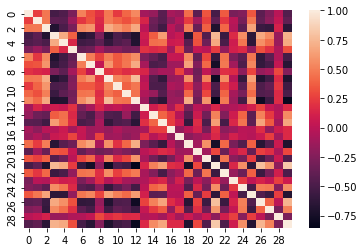

In [24]:
sns.heatmap(pd.DataFrame(f).corr())

In [25]:
env.engine.return_rgb = False

(pid=27932) E0205 16:34:13.204586 27932 27932 plasma_store_provider.cc:113] Failed to put object 43b4f69ac624688f62223d850100000001000000 in object store because it is full. Object size is 47770427 bytes.
(pid=27932) Waiting 8000ms for space to free up...
(pid=raylet) E0205 16:34:13.204452 27885 27900 store.cc:256] Not enough memory to create the object 43b4f69ac624688f62223d850100000001000000, data_size=47770427, metadata_size=6, will send a reply of PlasmaError::OutOfMemory


In [47]:
gin.bind_parameter('model_gnn/FCCombinedModel.activation_cls', torch.nn.LeakyReLU)
gin.bind_parameter('model_gnn/FCCombinedModel.hidden_sizes', [100, 100, 100])

In [48]:
learner.non_sparse_model.__init__(feature_shape=learner.feature_shape,
                                  action_shape=learner.action_shape,
                                  additional_feature_shape=learner.additional_feature_shape)
learner.non_sparse_model = learner.non_sparse_model.cuda()

In [49]:
learner.non_sparse_model.model.model.activation

[LeakyReLU(negative_slope=0.01),
 LeakyReLU(negative_slope=0.01),
 LeakyReLU(negative_slope=0.01),
 None]

In [50]:
learner.non_sparse_model

ManyNetworkCombinedModel(
  (bn): BatchNorm1d(34, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (model): WithInputSwitch(
    (switch): LearnableSwitchSimple()
    (model): FCCombinedModel(
      (fc01): CombinedLinearLayer()
      (fc02): CombinedLinearLayer()
      (fc03): CombinedLinearLayer()
      (fc04): CombinedLinearLayer()
    )
  )
)

In [51]:
learner.non_sparse_model.model.enable_switch

False

In [52]:
mins = None
maxes = None

In [53]:
def normalize(t, mins, maxes):
    return 2 * ((t - mins) / (1e-3 + maxes - mins) - 0.5)

In [54]:
class AdhocWorldModel(nn.Module):
    def __init__(self):
        super(AdhocWorldModel, self).__init__()
        dim = 60
        self.bn = torch.nn.BatchNorm1d(num_features=34)
        self.fc1 = nn.Linear(in_features=34, out_features=dim)
        self.fc2 = nn.Linear(in_features=dim, out_features=dim)
        self.fc3 = nn.Linear(in_features=dim, out_features=dim)
        self.fc4 = nn.Linear(in_features=dim, out_features=32)
        self.activation = nn.Tanh()
        
    def forward(self, f_t, a_t, all):
        x = torch.cat([f_t, a_t], dim=1)
        
        x = self.bn(x)
        
        x = self.fc1(x)
        x = self.activation(x)
        
        x = self.fc2(x)
        x = self.activation(x)
        
        x = self.fc3(x)
        x = self.activation(x)
        
        x = self.fc4(x)
        return x

In [78]:
losses = []
metrics = []
losses_emb = []
losses_fit = []

In [79]:
#use_model = learner.non_sparse_model
use_model = AdhocWorldModel().cuda()

In [80]:
gin.bind_parameter('decoder/FCNet.hidden_sizes', [512])
gin.bind_parameter('decoder/FCNet.activation_cls', torch.nn.LeakyReLU)

In [81]:
learner.decoder.__init__(observation_shape=learner.observation_shape,
                         feature_shape=learner.feature_shape)
learner.decoder = learner.decoder.cuda()

In [82]:
opt = torch.optim.Adam(lr=1e-3, params=list(use_model.parameters())+list(learner.decoder.parameters()))

In [83]:
def fit_loss(obs_x, obs_y, action_x, decoder, model, additional_feature_keys,
             model_forward_kwargs=None,
             fill_switch_grad=False,
             opt_label=None,
             divide_by_std=False,
             std_eps=0.05,
             **kwargs):
    """Ensure that the model fits the features data."""

    if model_forward_kwargs is None:
        model_forward_kwargs = {}
    
    f_t1 = decoder(obs_y)#.detach()
        
    have_additional = False
    if additional_feature_keys:
        have_additional = True
        add_features_y = torch.cat([kwargs[k] for k in additional_feature_keys], dim=1)
        
        # WARNING: zeroing output features
#         f_t1 = torch.zeros_like(f_t1)
        f_t1 = torch.cat([f_t1, add_features_y], dim=1)
        
    # detaching second part like in q-learning makes the loss jitter

    f_t1_pred = model(decoder(obs_x), action_x, all=have_additional, **model_forward_kwargs)

    loss = (f_t1_pred - f_t1).pow(2)
    loss = loss.sum(1).mean()

    metrics = {'mean_feature': f_t1.mean(0).detach().cpu().numpy(),
               'std_feature': f_t1.std(0).detach().cpu().numpy(),
               'min_feature': f_t1.min().item(),
               'max_feature': f_t1.max().item(),
               #'std_feature_avg': f_t1_std.detach().cpu().numpy() if f_t1_std is not None else 0.0,
               #'inv_std_feature_avg': 1/f_t1_std.detach().cpu().numpy() if f_t1_std is not None else 0.0
              }

    return {'loss': loss,
            'metrics': metrics}

In [84]:
[x.mean() for x in learner.decoder.state_dict().values()]

[tensor(-7.1260e-05, device='cuda:0'),
 tensor(-0.0004, device='cuda:0'),
 tensor(-0.0002, device='cuda:0'),
 tensor(-0.0099, device='cuda:0')]

In [88]:
ctx_set = False
for i in tqdm(range(10000)):
    if i % 1 == 0 or not ctx_set:
        ctx_set = True
        ctx = learner.collect_and_get_context()
        
#         if mins is None or maxes is None:
#             print("Computing minmax")
#             f_all = learner.decoder(ctx['obs'])
#             mins = f_all.min(dim=0, keepdim=True).values.detach()
#             maxes = f_all.max(dim=0, keepdim=True).values.detach()
        
#         f_t1 = learner.decoder(ctx['obs_y'])#.detach()
#         f_t = learner.decoder(ctx['obs_x'])#.detach()
        
# #         f_t1 = normalize(f_t1, mins, maxes)
# #         f_t = normalize(f_t, mins, maxes)
        
#         add_features_y = torch.cat([ctx[k] for k in ctx['additional_feature_keys']], dim=1)
#         f_t1 = torch.cat([f_t1, add_features_y], dim=1)
        
#     f_t1_pred = use_model(
#         f_t,
#         ctx['action_x'],
#         all=True)
    
    ctx['non_sparse_model_add'] = use_model
#     ctx['additional_feature_keys'] = []
    l_obj_emb = siamese_feature_discriminator_l2(**ctx)
    l_obj_fit = context_rewriter(function=fit_loss, rewrite={'model': 'non_sparse_model_add'},
                                 divide_by_std=False,
                                 **ctx)
    loss = l_obj_fit['loss'] #+ l_obj_emb['loss']

    
#     loss = nn.MSELoss()(f_t1, f_t1_pred)

    
    opt.zero_grad()
    loss.backward()
    opt.step()
    losses.append(loss.item())
    losses_emb.append(l_obj_emb['loss'].item())
    losses_fit.append(l_obj_fit['loss'].item())
    m = {}
    m.update(l_obj_fit['metrics'])
    m.update(l_obj_emb['metrics'])
    metrics.append(m)

KeyboardInterrupt: 

In [89]:
learner.model

ManyNetworkCombinedModel(
  (bn): BatchNorm1d(34, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (model): WithInputSwitch(
    (switch): LearnableSwitchSimple()
    (model): FCCombinedModel(
      (fc01): CombinedLinearLayer()
      (fc02): CombinedLinearLayer()
      (fc03): CombinedLinearLayer()
      (fc04): CombinedLinearLayer()
    )
  )
)

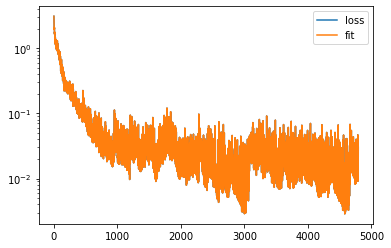

In [90]:
plt.plot(losses, label='loss')
# plt.plot(losses_emb, label='emb')
plt.plot(losses_fit, label='fit')
#plt.plot(dplus, label='dplus')
plt.yscale('log')
plt.legend()

In [43]:
f_t1 = learner.decoder(ctx['obs_y'])#.detach()
f_t = learner.decoder(ctx['obs_x'])#.detach()

#         f_t1 = normalize(f_t1, mins, maxes)
#         f_t = normalize(f_t, mins, maxes)

add_features_y = torch.cat([ctx[k] for k in ctx['additional_feature_keys']], dim=1)
f_t1 = torch.zeros_like(f_t1)
f_t1 = torch.cat([f_t1, add_features_y], dim=1)

f_t1_pred = use_model(
f_t,
ctx['action_x'],
all=True)


<AxesSubplot:>

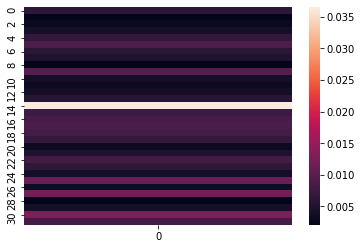

(pid=27932) E0205 16:38:31.923233 27932 27932 plasma_store_provider.cc:113] Failed to put object e9c1e546b44a7a7a62223d850100000001000000 in object store because it is full. Object size is 47760224 bytes.
(pid=27932) Waiting 1000ms for space to free up...
(pid=raylet) E0205 16:38:31.923147 27885 27900 store.cc:256] Not enough memory to create the object e9c1e546b44a7a7a62223d850100000001000000, data_size=47760224, metadata_size=6, will send a reply of PlasmaError::OutOfMemory


In [44]:
sns.heatmap((f_t1_pred - f_t1).pow(2).mean(0).cpu().detach().numpy().reshape(-1, 1))

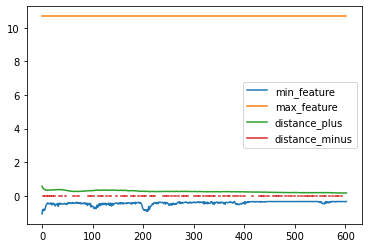

In [80]:
metrics_dct = lstdct2dctlst(metrics)
for key, vals in metrics_dct.items():
    if len(np.array(vals).shape) > 1: continue
    plt.plot(vals, label=key)
plt.legend()
plt.show()

In [81]:
metrics_dct.keys()

dict_keys(['mean_feature', 'std_feature', 'min_feature', 'max_feature', 'distance_plus', 'distance_minus'])

(pid=26583) E0205 16:23:41.700220 26583 26583 plasma_store_provider.cc:113] Failed to put object 7eb81b4da76c52a33db7cfef0100000001000000 in object store because it is full. Object size is 47770427 bytes.
(pid=26583) Waiting 1000ms for space to free up...
(pid=raylet) E0205 16:23:41.699122 26556 26567 store.cc:256] Not enough memory to create the object 7eb81b4da76c52a33db7cfef0100000001000000, data_size=47770427, metadata_size=6, will send a reply of PlasmaError::OutOfMemory


In [82]:
losses[-1]

0.04357163608074188

In [83]:
learner.decoder(ctx['obs_x']).min()

tensor(-0.3339, device='cuda:0', grad_fn=<MinBackward1>)

In [ ]:
# metrics_dct['']